In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
from bokeh.plotting import output_notebook, figure, show
from matplotlib.ticker import LogLocator
import numpy as np

START_TIME = 1.0 # in seconds
BW = 100 # in Gbps
PORT_NO_START = 1000

LINE_STYLE = (0,(4,4))
figsize = (6,3)
SAVE_FIG = False

In [ ]:
#@title
def read_flow_stats(flow_stats_filename):

  flow_stats = {}
  with open(flow_stats_filename, 'r') as f:
    for line in f:
      flow_stat_log = line.split()

      time = float(flow_stat_log[0])*1e-9 - START_TIME # in seconds
      sender = flow_stat_log[1]
      cwnd = float(flow_stat_log[4]) * 1e-3 # in KB
      rtt = float(flow_stat_log[5]) * 1e-3 # in usec

      if (rtt != 0):
        rate = cwnd * 8.0 / rtt # in Gbps
      elif (cwnd != 0):
        rate = BW

      if sender in flow_stats.keys():
        flow_stats[sender]['times'].append(time)
        flow_stats[sender]['rates'].append(rate)
        flow_stats[sender]['cwnds'].append(cwnd)
        flow_stats[sender]['rtts'].append(rtt)
      else:
        flow_stats[sender] = {}
        flow_stats[sender]['times'] = [time]
        flow_stats[sender]['rates'] = [rate]
        flow_stats[sender]['cwnds'] = [cwnd]
        flow_stats[sender]['rtts'] = [rtt]

  return flow_stats

In [ ]:
#@title
def read_queue_log(filename):
  retval = {}
  retval['times'] = []
  retval['q_sizes'] = []
  with open(filename, 'r') as f:
    for line in f:
      queue_log = line.split()
      try:
        time = float(queue_log[0])*1e-9 - START_TIME # in seconds
        q_size = float(queue_log[1]) * 8.0 / BW * 1e-3 # in usec
      except:
        continue

      retval['times'].append(time)
      retval['q_sizes'].append(q_size)

  return retval

# SWIFT - Effect of Feedback Delay to Convergence at New Flow Arrival

In [ ]:
artDels = ['0', '500', '1000', '2000', '4000', '8000', '16000'] 
# artDels = ['No', 'Rtt', 'BtsEgress', 'BtsIngress'] # 'RttNoQ', 'Q' 

In [ ]:
flow_stats_data = {}
qlog_data = {}
folder_path = 'outputs/bolt-bts-benchmarks/'
for artDel in artDels:
  filename = folder_path + 'ArtDel' + artDel + '_0_MSGAGG_SWIFT_FF_BTS_PERHOP'
  flow_stats_filename = filename + '.log'
  qlog_filename = filename + '.qlen'
  flow_stats_data[artDel] = read_flow_stats(flow_stats_filename)
  qlog_data[artDel] = read_queue_log(qlog_filename)

# filename = folder_path + 'ArtDelNo_0_MSGAGG_SWIFT'
# flow_stats_filename = filename + '.log'
# qlog_filename = filename + '.qlen'
# flow_stats_data['Original'] = read_flow_stats(flow_stats_filename)
# qlog_data['Original'] = read_queue_log(qlog_filename)

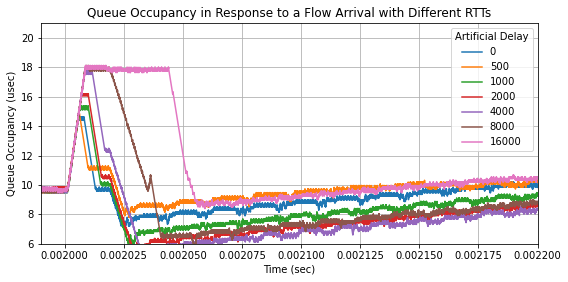

In [ ]:
#@title
plt.figure(figsize=(8,4))
xlim = [0.00199, 0.0022]

for key, data in qlog_data.items():
  plt.plot(data['times'],data['q_sizes'], label=key)

if xlim is not None:
  plt.xlim(xlim)
plt.ylim([6, 21])

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Arrival with Different RTTs')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.legend(title='Artificial Delay')
plt.tight_layout()

plt.show()

In [ ]:
#@title
output_notebook()
p = figure(plot_width=900, plot_height=400)
# print(plt.rcParams['axes.prop_cycle'].by_key()['color'])
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
idx = 0
for key, data in qlog_data.items():
  p.line(data['times'],data['q_sizes'], 
           legend_label=key, line_color=colors[idx])
  idx += 1

show(p)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
convergence_times = {
    '0':1e6 * (-0.0020013+0.0020134),
    # '0.5':1e6 * (-0.0020013+0.00202),
    '1':1e6 * (-0.0020013+0.0020208),
    '2':1e6 * (-0.0020013+0.0020222),
    '4':1e6 * (-0.0020013+0.0020243),
    '8':1e6 * (-0.0020013+0.0020352),
    '16':1e6 * (-0.0020013+0.002054)
}
feedback_convergence_times = {
    'Ing':1e6 * (-0.002002+0.002023),
    'Egr':1e6 * (-0.002002+0.002038),
    'Rcvr':1e6 * (-0.002002+0.002057)
}

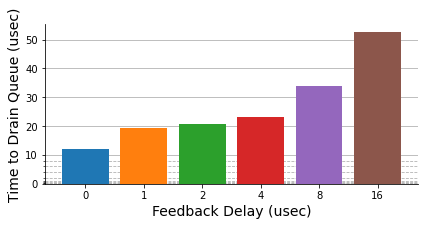

In [ ]:
#@title
fontsize = 14
plt.figure(figsize=figsize)
plt.bar(list(convergence_times.keys()),list(convergence_times.values()),
        color=colors)
# plt.yscale('log')
plt.xlabel('Feedback Delay (usec)', fontsize=fontsize)
plt.ylabel('Time to Drain Queue (usec)', fontsize=fontsize)
# plt.title('Convergence Time of Swift with respect to the Feeedback Delay')
plt.gca().set_axisbelow(True)
plt.gca().yaxis.set_minor_locator(LogLocator(base = 10.0, subs = np.arange(1.0, 5.0) * 0.2, numticks = 5))
plt.grid(axis='y')
plt.grid(axis='y', which='minor', linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

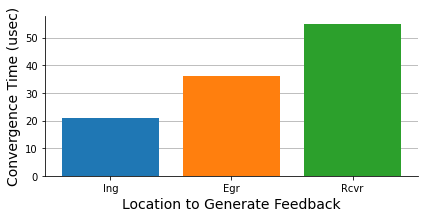

In [ ]:
#@title
fontsize = 14
figsize = (6,3)
plt.figure(figsize=figsize)
plt.bar(list(feedback_convergence_times.keys()),list(feedback_convergence_times.values()),
        color=colors)
# plt.yscale('log')
plt.xlabel('Location to Generate Feedback', fontsize=fontsize)
plt.ylabel('Convergence Time (usec)', fontsize=fontsize)
# plt.title('Convergence Time of Swift with respect to the Feeedback Delay')
plt.gca().set_axisbelow(True)
# plt.gca().yaxis.set_minor_locator(LogLocator(base = 10.0, subs = np.arange(1.0, 5.0) * 0.2, numticks = 5))
plt.grid(axis='y')
plt.grid(axis='y', which='minor', linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

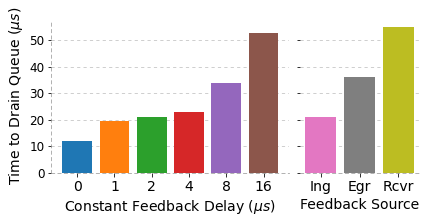

In [ ]:
#@title
f, (a0, a1) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [2, 1]}, sharey=True)

a0.bar(list(convergence_times.keys()),list(convergence_times.values()),
        color=colors)
# a0.set_yscale('log')
a0.set_xlabel('Constant Feedback Delay ($\\mu s$)', fontsize=fontsize)
for label in (a0.get_xticklabels()): 
  label.set_fontsize(fontsize)
a0.set_ylabel('Time to Drain Queue ($\\mu s$)', fontsize=fontsize)
for label in (a0.get_yticklabels()): 
  label.set_fontsize(fontsize-2)
# a0.title('Convergence Time of Swift with respect to the Feeedback Delay')
a0.set_axisbelow(True)
# a0.yaxis.set_minor_locator(LogLocator(base = 10.0, subs = np.arange(1.0, 5.0) * 0.2, numticks = 5))
a0.grid(axis='y', alpha=0.75, linestyle=LINE_STYLE)
# a0.grid(axis='y', which='minor', linestyle='--')
a0.spines['top'].set_visible(False)
a0.spines['right'].set_visible(False)
plt.tight_layout()

a1.bar(list(feedback_convergence_times.keys()),list(feedback_convergence_times.values()),
        color=colors[6:])
# a1.yscale('log')
a1.set_xlabel('Feedback Source', fontsize=fontsize)
for label in (a1.get_xticklabels()): 
  label.set_fontsize(fontsize)
# a1.ylabel('Convergence Time (usec)', fontsize=fontsize)
# a1.yticks(visible=False)
# a1.title('Convergence Time of Swift with respect to the Feeedback Delay')
a1.set_axisbelow(True)
# a1.yaxis.set_minor_locator(LogLocator(base = 10.0, subs = np.arange(1.0, 5.0) * 0.2, numticks = 5))
a1.grid(axis='y', alpha=0.75, linestyle=LINE_STYLE)
# a1.grid(axis='y', which='minor', linestyle='--')
a1.spines['left'].set_visible(False)
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)

a0.spines["right"].set_linestyle(LINE_STYLE)
a0.spines["right"].set_alpha(0.75)
a0.spines["right"].set_color('gray')
a0.spines["left"].set_linestyle(LINE_STYLE)
a0.spines["left"].set_alpha(0.75)
a0.spines["left"].set_color('gray')
a0.spines["top"].set_linestyle(LINE_STYLE)
a0.spines["top"].set_alpha(0.75)
a0.spines["top"].set_color('gray')
a0.spines["bottom"].set_linestyle(LINE_STYLE)
a0.spines["bottom"].set_alpha(0.75)
a0.spines["bottom"].set_color('gray')
a1.spines["right"].set_linestyle(LINE_STYLE)
a1.spines["right"].set_alpha(0.75)
a1.spines["right"].set_color('gray')
a1.spines["left"].set_linestyle(LINE_STYLE)
a1.spines["left"].set_alpha(0.75)
a1.spines["left"].set_color('gray')
a1.spines["top"].set_linestyle(LINE_STYLE)
a1.spines["top"].set_alpha(0.75)
a1.spines["top"].set_color('gray')
a1.spines["bottom"].set_linestyle(LINE_STYLE)
a1.spines["bottom"].set_alpha(0.75)
a1.spines["bottom"].set_color('gray')

f.tight_layout()

if (SAVE_FIG):
  plt.savefig('/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/feedback_vs_ConvergenceTime.pdf')
plt.show()